# Approach

In this notebook, I perform K-means and NMF (which under certain assumptions is identical to the K-means algorithm) on the TCGA cancer data. Recall: K-means and NMF are both unsupervised clustering methods. Given that PCA and UMAP were unable to reveal clustering structures on dimensionally-reduced data, I don't expect K-means to perform well as a classifier.

So, why do it?

An obvious answer is that we would like to see how well unsupervised clustering will perform on this data. In my opinion, a less obvious answer is that the `luminal A` and `luminal B` classifications of breast cancer have been arrived at through immunohistochemical analyses of a small number of biomarkers, but it is possible that these `luminal cancer` samples represent more than two cancer types. For the case of cluster selection, there's really no alternative other than unsupervised clustering algorithms. At any rate, let's see what we get.

In [2]:
import pandas as pd
import numpy as np
import scanpy as sc

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib import rc
from sklearn.cluster import KMeans
from sklearn.decomposition import NMF

rc('text', usetex=True)
rc('text.latex', preamble=r'\usepackage{cmbright}')
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})

%matplotlib inline

# This enables SVG graphics inline. 
%config InlineBackend.figure_formats = {'png', 'retina'}

rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

mpl.rcParams['xtick.labelsize'] = 16 
mpl.rcParams['ytick.labelsize'] = 16 
mpl.rcParams['legend.fontsize'] = 14

ensembl = sc.queries.biomart_annotations(org='hsapiens',
                                         attrs=['ensembl_gene_id', 'gene_biotype',
                                                'external_gene_name', 'description'])

Load data

In [3]:
df = pd.read_csv('../luminalAB/mrna/trimmedTMM.csv', index_col='geneid')
logdf = pd.read_csv('../luminalAB/mrna/logTMM.csv', index_col='geneid')
normed = pd.read_csv('../luminalAB/mrna/NormalizedlogTMM.csv', index_col='geneid')
meta = pd.read_csv('../luminalAB/mrna/lumAB_id_cancer.txt', sep='\t')
meta.ID = meta.ID.astype('category')
meta.ID.cat.set_categories(df.columns, inplace=True)
meta.sort_values("ID", inplace=True)
ensembl = ensembl[ensembl.ensembl_gene_id.isin(df.index)]

In [5]:
def generate_train_and_test(data):
    """
    Given a dataframe `data`, assign 2/3 of the data to a training set, and the remaining to a test set.
    `sklearn` probably has a function for this, but too lazy to look it up.
    Ideally this function should have a seed in it for reproducibility, but too lazy to do this right now.

    Params:
    data:    pd.DataFrame.
    
    Output:
    train:    tuple. First entry contains the training expression data, second entry contains training labels
    test:    tuple. First entry contains the testing expression data, second entry contains testing labels
    """
    # generate indices to subset data with:
    train_idx = np.random.choice(data.T.index.values,
                                 size=np.int(np.floor(len(data.columns) / 3 * 2)),
                                replace=False).tolist()
    test_idx = [n for n in data.T.index if n not in train_idx]

    # fetch data:
    train_exp = data.T[data.T.index.isin(train_idx)]
    train_labels = meta[meta.ID.isin(train_idx)].cancer 

    test_exp = data.T[data.T.index.isin(test_idx)]
    test_labels = meta[meta.ID.isin(test_idx)].cancer
    
    # return data
    train = (train_exp, train_labels)
    test = (test_exp, test_labels)
    return train, test

In [6]:
# a quick function to dummify data:
label = lambda x: 'Luminal_A' if x == 1 else 'Luminal_B'
train, test = generate_train_and_test(normed)

# Perform K-means algorithm using 2 clusters

In [7]:
kmeans = KMeans(n_clusters=2, algorithm='full', random_state=0).fit(train[0])
score = ([label(k) for k in kmeans.predict(test[0])] == test[1]).sum() / len(test[1])
print('K-means Out of the box performance is: {0:.2g}'.format(score))
print('Fraction of Luminal_A in test set: {0:.2g}'.format((test[1] == 'Luminal_A').sum() / len(test[1])))

K-means Out of the box performance is: 0.72
Fraction of Luminal_A in test set: 0.7


In [8]:
kmeans = KMeans(n_clusters=2, algorithm='full', random_state=5).fit(train[0])
score = ([label(k) for k in kmeans.predict(test[0])] == test[1]).sum() / len(test[1])
print('K-means Out of the box performance is: {0:.2g}'.format(score))
print('Fraction of Luminal_A in test set: {0:.2g}'.format((test[1] == 'Luminal_A').sum() / len(test[1])))

K-means Out of the box performance is: 0.29
Fraction of Luminal_A in test set: 0.7


So, we have a problem. In the code above, I've run K-means twice. The problem is that in one iteration, the out-of-the-box performance is 72% (i.e., 72% of all labels are correct). This doesn't sound awful -- we are beating a coin, but actually, we could get to 70% accuracy just by calling all the samples `Luminal A`. So, in a sense, we are not doing much better than calling everything `Luminal A` (of course, we could look at an ROC curve or other metrics that would show we are likely outperforming calling everything `Luminal A`, but we'd like to improve along ALL possible summary statistics, right?

I suppose there are two ways to interpret this result. First, we might conclude that `Luminal A` and `Luminal B` cancers are very similar, so classifying them is very difficult. Another possibility is that there's more than two clusters. 

# How many clusters *are* there?

We can think of the K-means algorithm as a matrix reconstruction problem, where samples are assigned to latent classes described by combinations of gene expression levels. As we increase the number of latent classes, the matrix reconstruction gets better until every sample is its own latent class. However, that limit is not useful. Intuitively, there must be a trade-off between reconstruction accuracy and the number of trade-offs. We would like to penalize matrix reconstructions that use a large number of latent class in order to generate an inverted **U** curve that shows us a solution that both reconstructs the data accurately AND has relatively few clusters. We could define such a function to be:

$$
L = S + 1,000\cdot i^2
$$

In this case, $L$ is our loss function, $S$ is the inertia of the K-means solution (think of this as the reconstruction error) and $i$ is the number of clusters. 

Now, we can build code that will explore a range of clusters and figure out their loss function values. However, keeping in mind that the reconstructions vary from run to run, we should probably re-run the K-means algorithm a few times to make sure the reconstruction we got any one time is not a particularly good or bad one.

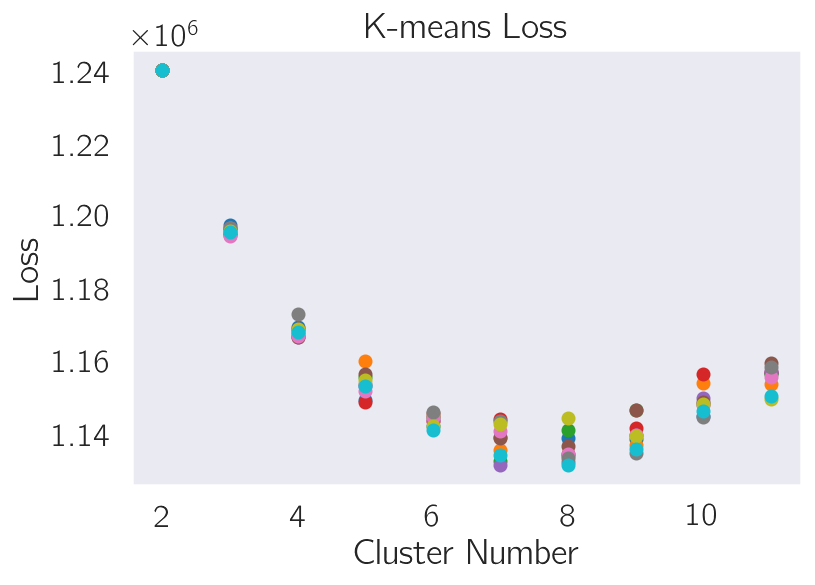

In [9]:
for j in range(10):
    loss = []
    for i in range(2, 12):
        # run kmeans
        kmeans = KMeans(n_clusters=i, algorithm='full').fit(train[0])
        loss += [kmeans.inertia_ + 10 ** 3 * i ** 2]
    # plot results:
    plt.scatter(range(2, 12), loss)

# prettify
plt.xlabel('Cluster Number')
plt.ylabel('Loss')
_ = plt.title('K-means Loss')

It would appear that the K-means algorithm subject to the aforementioned loss-function thinks the data can best be explained by clusters 7 or maybe 8 clusters. The curve appears to be pretty flat in that region, which is interesting. However, please note this minimum is strongly subject to the penalty associated with the cluster number: if we decrease the penalty, the loss function will be minimized at higher cluster numbers, so it's a good idea to think about how to select that parameter. Such a topic is beyond the scope of this notebook, but a good rule of thumb probably is that the cluster number penalty must achieve comparable values to the reconstruction error values (otherwise, the loss function will be dominated entirely by the reconstruction term)

# How many clusters does NMF think there are?

I've said before that NMF is approximately the same to K-means. So let's try running that here, using the loss function:

$$
L = S_{NMF} + i^2
$$

Please note that since NMF accepts non-negative values only, we will not use the scaled data. Instead, we will use log(TMM + 1) data, but we will subset it in the same way as the K-means data. We could re-scale the data by dividing each gene expression level by  its standard deviation but I'm lazy.

In [10]:
train, test = generate_train_and_test(logdf)
loss = []
for i in range(2, 6):
    nmf = NMF(i, max_iter=10000, alpha=0.3, init='nndsvd', l1_ratio=0.3)
    W = nmf.fit_transform(train[0])
    loss += [nmf.reconstruction_err_ + i ** 2]

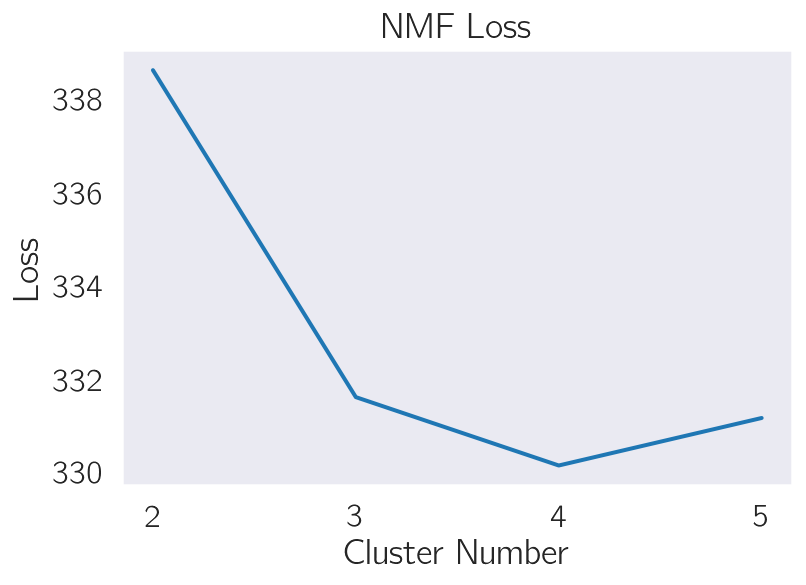

In [11]:
plt.plot(range(2, 6), loss)
plt.xlabel('Cluster Number')
plt.ylabel('Loss')
_ = plt.title('NMF Loss')

NMF seems to think there's between 3 and 5 clusters, subject to the loss function we defined. Both algorithms seem to think we should split up the luminal cancers a bit more to really explain variation well.